# 4: Geocentric Models

In [1]:
%cd ~/statistical-rethinking/
import sys

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.tensor as tt
import pyro
from pyro.distributions import Uniform, Normal, Exponential

sys.path.insert(0, "/home/ecotner/statistical-rethinking/code")
from utils import HPDI

/home/ecotner/statistical-rethinking


### Code 4.1
Simulate 1000 people generating 16 numbers between -1 and 1

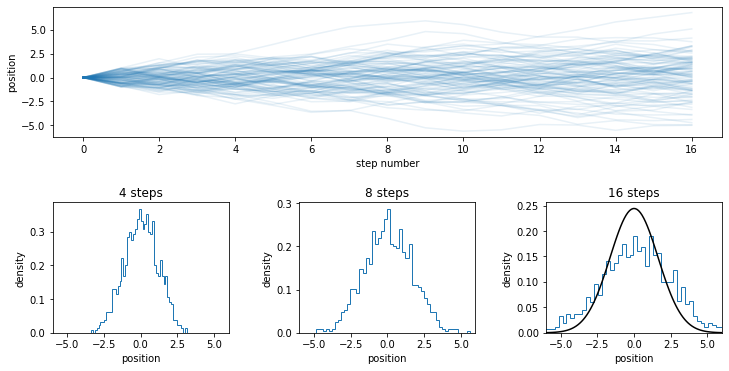

In [2]:
# Generate the numbers
x = (st.uniform.rvs(size=(1000, 16))-0.5)*2
# Make the plots
fig = plt.figure(figsize=(12, 6))
# Random walk illustration
ax1 = fig.add_subplot(211)
for steps in np.hstack([np.zeros((100, 1)), x[:100]]):
    plt.plot(np.cumsum(steps), color="C0", alpha=0.1)
ax1.set_xlabel("step number")
ax1.set_ylabel("position")
# Sequence of distributions
x = np.cumsum(x, axis=1)
for i, step in enumerate((4, 8, 16)):
    ax = fig.add_subplot(234+i)
    ax.hist(x[:,step-1], bins=50, density=True, histtype="step")
    ax.set_xlabel("position")
    ax.set_ylabel("density")
    ax.set_title(f"{step} steps")
    ax.set_xlim(left=-6, right=+6)
# Plot a gaussian approximation to the sum
var = (1/12)*(1-(-1)) # Variance of single uniform distribution
var *= 16 # Approx variance of sum of 16 iid uniforms
x = np.linspace(-6, 6, 100)
y = st.norm.pdf(x, scale=np.sqrt(var))
ax.plot(x, y, color="black")
plt.subplots_adjust(hspace=0.5, wspace=0.4)

### Code 4.2
Take the product of 12 random uniform numbers in the interval (1, 1.1)

In [3]:
np.prod(1 + 0.1*st.uniform.rvs(size=12))

1.8554240865261165

### Code 4.3
Now do the same thing 10,000 times and look at the distribution

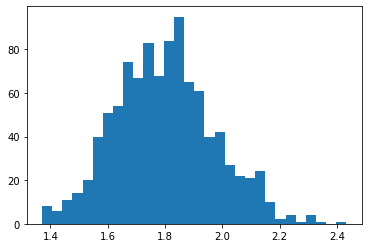

In [4]:
growth = np.prod(1 + 0.1*st.uniform.rvs(size=(1000, 12)), axis=1)
plt.hist(growth, bins=30)
plt.show()

### Code 4.4
Compare the effects of big and small multiplicative steps on convergence towards normality

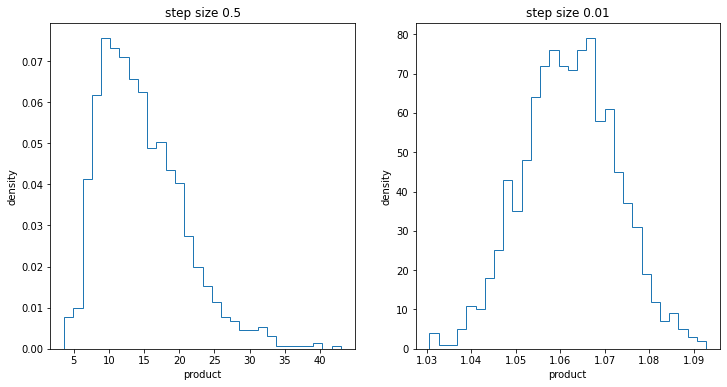

In [5]:
# Generate numbers
big = np.prod(1 + 0.5*st.uniform.rvs(size=(1000, 12)), axis=1)
small = np.prod(1 + 0.01*st.uniform.rvs(size=(1000, 12)), axis=1)
# Plot!
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
# Big
plt.sca(axes[0])
plt.hist(big, bins=30, histtype="step", density=True)
plt.xlabel("product")
plt.ylabel("density")
plt.title("step size 0.5")
# Small
plt.sca(axes[1])
plt.hist(small, bins=30, histtype="step")
plt.xlabel("product")
plt.ylabel("density")
plt.title("step size 0.01")
plt.show()

### Code 4.5
Multiplication is equivalent to addition on a log scale, i.e.
$$
\log\left(\prod_i x_i\right) = \sum_i \log(x_i)
$$

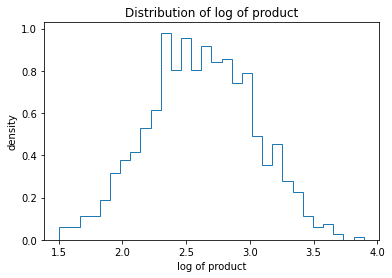

In [6]:
log_big = np.log(np.prod(1 + 0.5*st.uniform.rvs(size=(1000, 12)), axis=1))
plt.hist(log_big, bins=30, histtype="step", density=True)
plt.xlabel("log of product")
plt.ylabel("density")
plt.title("Distribution of log of product")
plt.show()

### Code 4.6
Redo the globe-tossing model for some reason?

In [7]:
w = 6; n = 9
p_grid = np.linspace(0, 1, 100)
posterior = st.binom(n=n, p=p_grid).pmf(6) * st.uniform.pdf(p_grid)
posterior /= posterior.sum()

### Code 4.7/4.8/4.9/4.10
Load some data on foraging populations conducted by Nancy Howell in the 1960's

In [8]:
howell_df = pd.read_csv("data/Howell1.csv", sep=";")
print("Number of rows:", len(howell_df))
howell_df.sample(6).T

Number of rows: 544


,503,304,211,542,114,274
height,123.82500,155.575000,154.305000,71.120000,111.760000,159.4
weight,21.54562,50.915702,46.776675,8.051258,15.081934,44.4
age,11.00000,50.000000,51.000000,0.000000,9.000000,54.0
male,1.00000,1.000000,0.000000,1.000000,1.000000,1.0


In [9]:
# Man, McElreath's `precis` function makes ascii histograms??!
howell_df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


In [10]:
# This just accesses the 'height' column...
howell_df["height"];

### Code 4.11
Filter out only individuals younger than 18

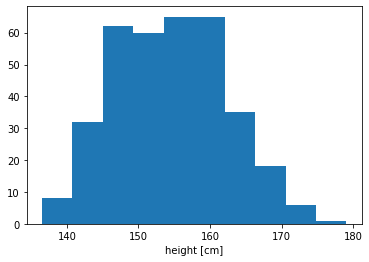

In [11]:
d2 = howell_df[howell_df["age"] >= 18]
plt.hist(d2["height"])
plt.xlabel("height [cm]")
plt.show()

### Code 4.12/4.13
Plot the priors for our height model,
$$
h_i \sim \text{Normal}(\mu, \sigma) \\
\mu \sim \text{Normal}(178, 20) \\
\sigma \sim \text{Uniform}(0, 50)
$$

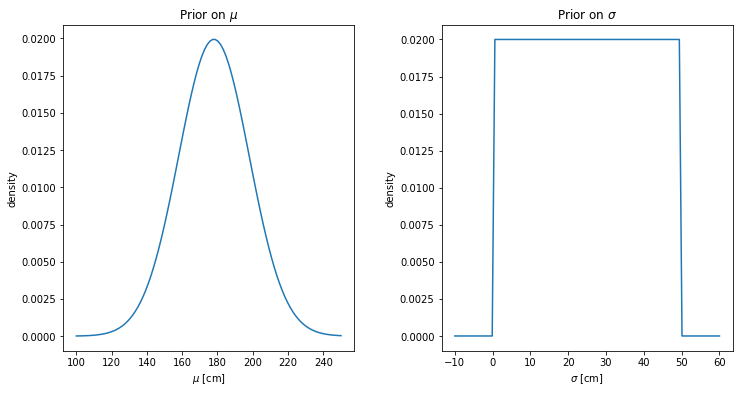

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# mu prior
plt.sca(axes[0])
x = torch.linspace(100, 250)
y = Normal(178, 20).log_prob(x).exp()
plt.plot(x, y)
plt.title("Prior on $\mu$")
plt.xlabel("$\mu$ [cm]")
plt.ylabel("density")
# sigma prior
plt.sca(axes[1])
x = torch.linspace(-10, 60)
y = Uniform(0, 50).log_prob(x).exp()
plt.plot(x, y)
plt.title("Prior on $\sigma$")
plt.xlabel("$\sigma$ [cm]")
plt.ylabel("density")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 4.14
Sample from the prior predictive for the $h_i$

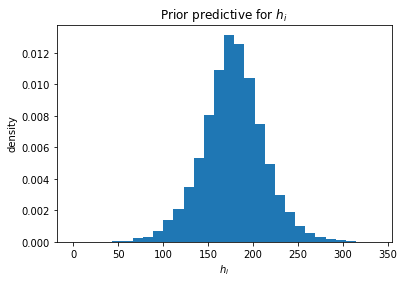

In [13]:
mu = Normal(178, 20).sample([10000])
sigma = Uniform(0, 50).sample([10000])
h = Normal(mu, sigma).sample()
plt.hist(h, bins=30, density=True)
plt.title("Prior predictive for $h_i$")
plt.xlabel("$h_i$")
plt.ylabel("density")
plt.show()

### Code 4.15
Observe the effect of a flatter prior for $\mu$ on the prior predictive for $h_i$

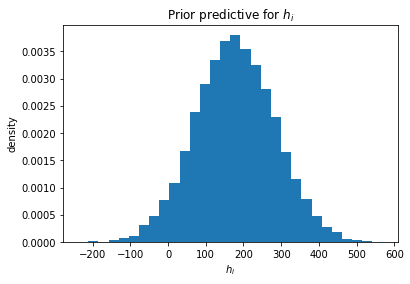

In [14]:
mu = Normal(178, 100).sample([10000])
sigma = Uniform(0, 50).sample([10000])
h = Normal(mu, sigma).sample()
plt.hist(h, bins=30, density=True)
plt.title("Prior predictive for $h_i$")
plt.xlabel("$h_i$")
plt.ylabel("density")
plt.show()

### Code 4.16
Use the grid approximation to calculate the posterior given the data

In [15]:
data = torch.tensor(d2["height"].values)
mu_grid = torch.linspace(150, 160, 100)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(7, 9, 100)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(data).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

### Code 4.17/4.18
Make a contour/heatmap plot of the posterior

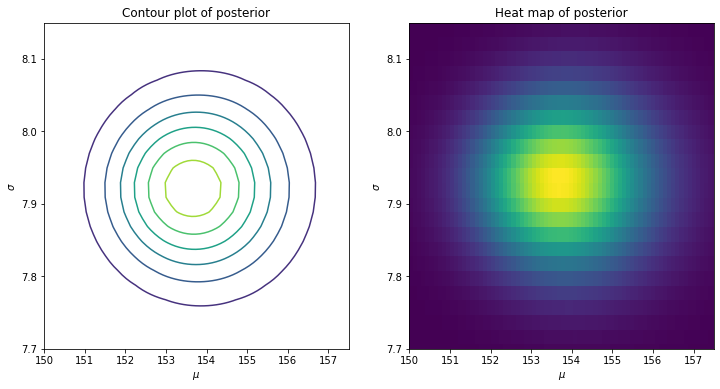

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
X, Y = np.meshgrid(mu_grid, sigma_grid)
plt.sca(axes[0])
plt.contour(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Contour plot of posterior")
plt.sca(axes[1])
plt.pcolormesh(X, Y, posterior)
plt.xlim(left=150, right=157.5)
plt.ylim(bottom=7.7, top=8.15)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Heat map of posterior")
plt.show()

### Code 4.19/4.20
Sample from the posterior and plot the samples

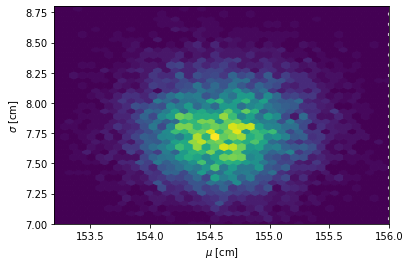

In [17]:
# The original grid was too coarse, so I'm gonna recompute on a smaller, finer grid
data = torch.tensor(d2["height"].values)
mu_grid = torch.linspace(153, 156, 500)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(7, 9, 500)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(data).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

# Sample from the posterior
idx = np.random.choice(np.prod(posterior.shape), p=posterior.flatten(), size=10000)
idx = np.vstack([idx//len(mu_grid), idx%len(mu_grid)])
samples = np.vstack((mu_grid[idx[0]], sigma_grid[idx[1]]))
plt.hexbin(*samples, gridsize=40)
# if you want to look at the scatter plot, though I don't think it's as useful:
# plt.scatter(*samples, s=0.5, alpha=0.1, color='red')
plt.xlim(left=153.2, right=156)
plt.ylim(bottom=7, top=8.8)
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.show()

### Code 4.21
Examine the marginal posterior densities of $\mu$ and $\sigma$

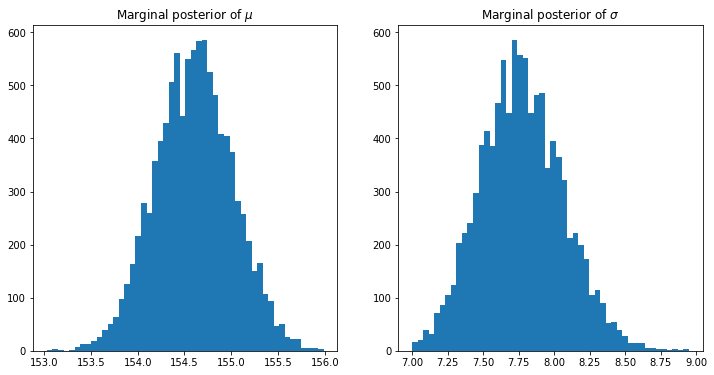

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
for i, label in enumerate(("mu", "sigma")):
    axes[i].hist(samples[i], bins=50)
    axes[i].set_title(f"Marginal posterior of $\{label}$")

### Code 4.22
Get the posterior credible intervals

In [19]:
print("mu CI:", HPDI(samples[0], 0.95))
print("sigma CI:", HPDI(samples[1], 0.95))

mu CI: (153.81764, 155.41684)
sigma CI: (7.200401, 8.334669)


### Code 4.23/4.24/4.25
Recalculate the posterior for using less data, and pay extra attention to the distribution in the $\sigma$ direction

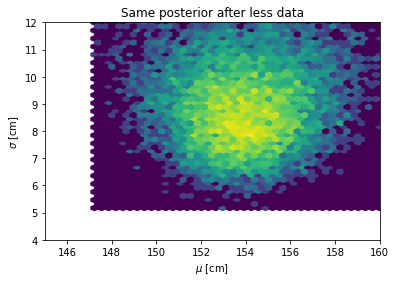

In [20]:
d3 = tt(d2["height"].sample(20).values)

mu_grid = torch.linspace(145, 160, 500)
mu_prior = Normal(178, 20).log_prob(mu_grid).view(-1, 1)
sigma_grid = torch.linspace(4, 12, 500)
sigma_prior = Uniform(0, 50).log_prob(sigma_grid).view(1, -1)
posterior = (
    # Likelihood
    Normal(mu_grid.view(-1, 1, 1), sigma_grid.view(1, -1, 1)).log_prob(d3).sum(axis=-1)
    # Priors
    + mu_prior + sigma_prior
)
posterior = torch.exp(posterior - posterior.max()) # Numerical trick to avoid overflow
posterior /= posterior.sum() # Normalize

# Sample from the posterior
idx = np.random.choice(np.prod(posterior.shape), p=posterior.flatten(), size=10000)
idx = np.vstack([idx//len(mu_grid), idx%len(mu_grid)])
samples = np.vstack((mu_grid[idx[0]], sigma_grid[idx[1]]))
plt.hexbin(*samples, gridsize=40, bins="log")
# if you want to look at the scatter plot, though I don't think it's as useful:
# plt.scatter(*samples, s=0.5, alpha=0.1, color='red')
plt.xlim(left=mu_grid[0], right=mu_grid[-1])
plt.ylim(bottom=sigma_grid[0], top=sigma_grid[-1])
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.title("Same posterior after less data")
plt.show()

Marginalize the posterior - note that sigma has a much heavier tail!

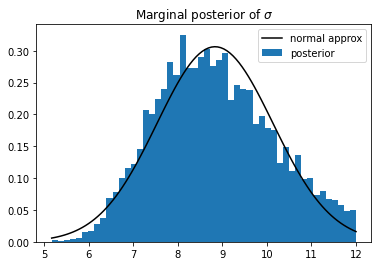

In [21]:
plt.hist(samples[1], bins=50, density=True, label="posterior")
mean = samples[1].mean()
std = samples[1].std()
x = np.linspace(samples[1].min(), samples[1].max(), 100)
y = st.norm(loc=mean, scale=std).pdf(x)
plt.plot(x, y, color='black', label="normal approx")
plt.title(f"Marginal posterior of $\sigma$")
plt.legend()
plt.show()

### Code 4.26/4.27/4.28/4.29
Compute the quadratic (Laplace) approximation to the posterior. There is no `quap` function available in python, so the first time I did this (in chapter 3?) I made the MAP estimate by hand, using gradient descent to find the posterior maximum, then got the second derivative at this location to estimate the standard deviation.

Now, I'm going to do it the `pyro` way. `pyro` has a handy class of objects called auto-guides which automatically construct a quick variational posterior for you to use with their Stochastic Variational Inference (SVI) algorithms. They conveniently have one called `AutoLaplaceApproximation`, which does the same thing a `quap`.

In [22]:
from pyro.infer.autoguide import AutoLaplaceApproximation, init_to_value
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import SGD

In [23]:
# Construct the dataset
d2 = tt(howell_df[howell_df["age"] >= 18]["height"].values)

# Specify the model
def model(data, train=True):
    mu = pyro.sample("mu", Normal(178, 20))
    sigma = pyro.sample("sigma", Uniform(0, 50))
    if train:
        with pyro.plate("obs", len(data)):
            pyro.sample("height", Normal(mu, sigma), obs=data)
    else:
        pyro.sample("height", Normal(mu, sigma))
            
# Specify the guide (using a handy Laplace approx.)
delta_guide = AutoLaplaceApproximation(
    model,
    init_to_value(values={"mu": d2.mean(), "sigma": d2.std()})
)

# Use SVI to get the MAP estimate
pyro.clear_param_store()
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
loss = [svi.step(d2) for _ in range(1000)]
# Expand around the posterior mode to get Laplace approx.
# AKA a multivariate normal
guide = delta_guide.laplace_approximation(d2)

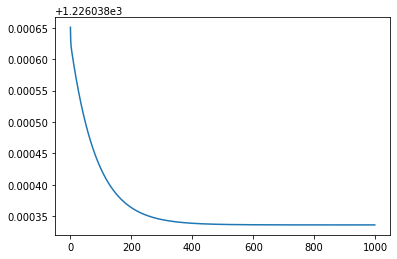

In [24]:
plt.plot(loss); plt.show()

In [25]:
# Here are the MAP estimates:
delta_guide()

{'mu': tensor(154.6070, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'sigma': tensor(7.7403, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [26]:
# Sample from the posterior
samples = {
    k: v.flatten().detach().numpy()
    for k, v in Predictive(model, guide=guide, num_samples=10000)(d2, False).items()
}

In [27]:
# Ok, he calls this often enough that I'll make it into a function...
def precis(samples: dict, prob=0.89):
    """Computes some summary statistics"""
    p1, p2 = (1-prob)/2, 1-(1-prob)/2
    cols = ["mean","stddev",f"{100*p1:.1f}%",f"{100*p2:.1f}%"]
    df = pd.DataFrame(columns=cols, index=samples.keys())
    for k, v in samples.items():
        df.loc[k]["mean"] = v.mean()
        df.loc[k]["stddev"] = v.std()
        q1, q2 = np.quantile(v, [p1, p2])
        df.loc[k][f"{100*p1:.1f}%"] = q1
        df.loc[k][f"{100*p2:.1f}%"] = q2
    return df

In [28]:
precis(samples)

,mean,stddev,5.5%,94.5%
mu,154.609,0.411491,153.945,155.268
sigma,7.74374,0.293406,7.28723,8.23058
height,154.661,7.76664,142.203,166.936


### Code 4.30
It is usually a good idea to give smart starting values when trying to find the MAP estimate. A good choice for $\mu$ and $\sigma$ are the sample mean and standard deviation of the height data. We already did this when initializing the guide in the above pyro model, but here's the values they would take:

In [29]:
print("initial mu:", d2.mean().item())
print("initial sigma:", d2.std().item())

initial mu: 154.5970926136364
initial sigma: 7.742332137351996


We can see they're already pretty close to the MAP values, which is good!

### Code 4.31
Redo the thing but with a much narrower prior on $\mu$ just to see what happens

In [30]:
# Construct the dataset
d2 = tt(howell_df[howell_df["age"] >= 18]["height"].values)

# Specify the model
def model(data, train=True):
    mu = pyro.sample("mu", Normal(178, 0.1))
    sigma = pyro.sample("sigma", Uniform(0, 50))
    if train:
        with pyro.plate("obs", len(data)):
            pyro.sample("height", Normal(mu, sigma), obs=data)
    else:
        pyro.sample("height", Normal(mu, sigma))
            
# Specify the guide (using a handy Laplace approx.)
delta_guide = AutoLaplaceApproximation(
    model,
    init_to_value(values={"mu": d2.mean(), "sigma": d2.std()})
)

# Use SVI to get the MAP estimate
pyro.clear_param_store()
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
loss = [svi.step(d2) for _ in range(100)]
    
# Expand around the posterior mode to get Laplace approx.
# AKA a multivariate normal
guide = delta_guide.laplace_approximation(d2)

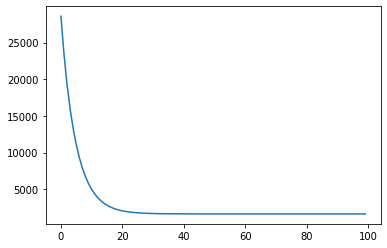

In [31]:
# Plot the loss
plt.plot(loss); plt.show()

We can see that the prior has very strongly affected the posterior - the MAP estimate is much closer to the mean of the prior than to the mean of the posterior, and the estimate for $\sigma$ is also much larger.

In [32]:
delta_guide()

{'mu': tensor(177.8630, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'sigma': tensor(24.5174, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [33]:
# Sample from the posterior
samples_ = {
    k: v.flatten().detach().numpy()
    for k, v in Predictive(model, guide=guide, num_samples=10000)(d2, False).items()
}
precis(samples_)

,mean,stddev,5.5%,94.5%
mu,177.864,0.101186,177.702,178.027
sigma,24.5244,0.928783,23.0432,26.0057
height,177.824,24.6965,138.135,217.253


### Code 4.32
Calculate the covariance of the posterior variables

In [34]:
np.cov([samples["mu"], samples["sigma"]])

array([[0.16934198, 0.00211278],
       [0.00211278, 0.08609575]])

### Code 4.33
Decompose the covariance into the variance vector and the correlation matrix. Recall that the covariance matrix is defined by
$$
\text{cov}(X_i, X_j) = \Sigma_{ij} = \frac{1}{N} \sum_{k=1}^N (\bar{x}_i - x_k) (\bar{x}_j - x_k)
$$
and the (Pearson) correlation coefficient by
$$
r(X_i, X_j) = \frac{\text{cov}(X_i, X_j)}{\sigma_i \sigma_j}
$$

In [35]:
cov = np.cov([samples["mu"], samples["sigma"]])
r = np.corrcoef([samples["mu"], samples["sigma"]]) # easier to use built-in functions
print("variance vector:\n", np.diag(cov))
print("correlation matrix:\n", r)

variance vector:
 [0.16934198 0.08609575]
correlation matrix:
 [[1.         0.01749768]
 [0.01749768 1.        ]]


### Code 4.34/4.35
Sample from the posterior... already done

In [36]:
pd.DataFrame(samples).head()

,mu,sigma,height
0,154.692250,8.149703,154.194371
1,155.314675,7.314997,160.713131
2,155.449544,7.949283,146.073570
3,154.900763,7.604814,142.421773
4,154.678852,7.604452,154.842736


In [37]:
precis(samples)

,mean,stddev,5.5%,94.5%
mu,154.609,0.411491,153.945,155.268
sigma,7.74374,0.293406,7.28723,8.23058
height,154.661,7.76664,142.203,166.936


### Code 4.36
Sample directly from a multivariate normal with the same parameters as the Laplace approx.

In [38]:
from pyro.distributions import MultivariateNormal

In [39]:
samples_ = tt(np.vstack([samples["mu"], samples["sigma"]]).T).float()
samples_ = MultivariateNormal(
    loc=samples_.mean(axis=0),
    covariance_matrix=tt(np.cov(samples_.T)).float()
).sample([10_000]).numpy()

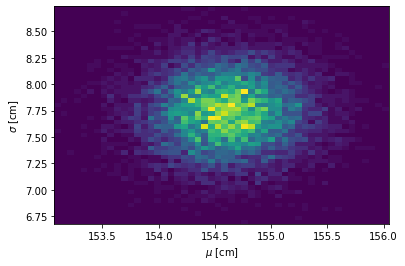

In [40]:
plt.hist2d(*samples_.T, bins=50)
plt.xlabel("$\mu$ [cm]")
plt.ylabel("$\sigma$ [cm]")
plt.show()

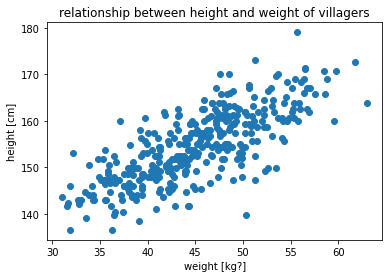

In [41]:
d2 = howell_df[howell_df["age"] >= 18]
plt.scatter(d2["weight"], d2["height"])
plt.xlabel("weight [kg?]")
plt.ylabel("height [cm]")
plt.title("relationship between height and weight of villagers")
plt.show()

### Code 4.38/4.39
Draw some samples from the prior and plot the resulting regression lines (I'll detail the model a couple cells after this)

In [42]:
N = 100
a = st.norm(loc=178, scale=20).rvs(N)
b = st.norm(loc=0, scale=10).rvs(N)

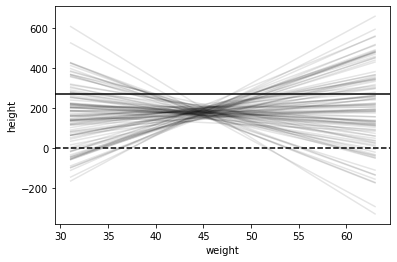

In [43]:
x = np.linspace(d2["weight"].min(), d2["weight"].max())
xbar = d2["weight"].mean()
for i in range(N):
    plt.plot(x, a[i] + b[i]*(x - xbar), color="black", alpha=0.1)
plt.axhline(272, color="black")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

The solid horizontal line is the world's tallest person, and the dashed horizontal line is a height of zero. Heights below zero are impossible, and heights above the world record are _incredibly_ unlikely. Is this really a good prior?

### Code 4.40
We can get a better prior by using a log-normal distribution for $\beta$ instead of a normal. Let's take a look at what one looks like:

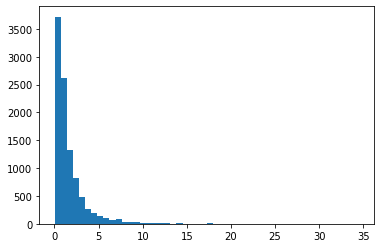

In [44]:
# if mu, sigma are the parameters for a normal distribution X, then
# the lognormal distribution Y = log(X) is parametrized by scale=exp(mu)
# and s=sigma (at least in scipy)
b = st.lognorm(scale=np.exp(0), s=1).rvs(10000)
plt.hist(b, bins=50)
plt.show()

In [45]:
from pyro.distributions import LogNormal

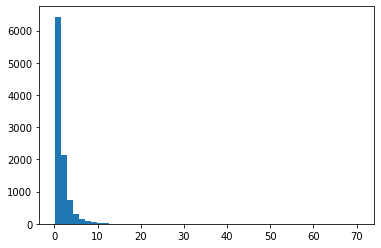

In [46]:
# in pyro, loc=mu and scale=sigma of the underlying
# normal distribution, quite contradictory to the way
# they're defined in scipy! just goes to show you
# should _always_ read the documentation before
# attempting to use any math-heavy libraries as
# different conventions for common things abound!
b = LogNormal(loc=0, scale=1).sample([10000])
plt.hist(b, bins=50)
plt.show()

### Code 4.41
Recreate the plot from 4.39, but with this log-normal prior on $\beta$

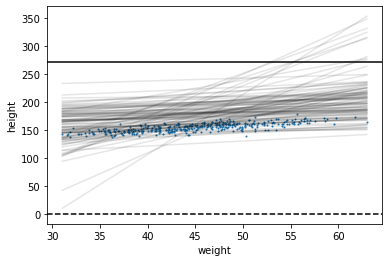

In [47]:
# Sample from new prior
N = 100
a = st.norm(loc=178, scale=20).rvs(N)
b = st.lognorm(scale=np.exp(0), s=1).rvs(N)

# Plot regression lines from the prior
x = np.linspace(d2["weight"].min(), d2["weight"].max())
xbar = d2["weight"].mean()
for i in range(N):
    plt.plot(x, a[i] + b[i]*(x - xbar), color="black", alpha=0.1)
plt.axhline(272, color="black")
plt.axhline(0, color="black", linestyle="--")

# Plot the data too for comparison
plt.scatter(d2["weight"], d2["height"], s=1)
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

This looks much more sensible; even though it seems that the tail of $\beta$ puts a bit too much emphasis on large slopes.

### Code 4.42
Build the linear regression model and get the quadratic posterior approximation. The model is given by

$$
\begin{align}
h_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta(x_i + \bar{x}) \\
\alpha &\sim \text{Normal}(178, 20) \\
\beta &\sim \text{Log-Normal}(0, 1) \\
\sigma &\sim \text{Uniform}(0, 50)
\end{align}
$$

In [48]:
# Format data
d2 = howell_df[howell_df["age"] >= 18]
weight = tt(d2["weight"].values).float()
height = tt(d2["height"].values).float()

In [49]:
# Create model/guide
def model(weight, height=None):
    alpha = pyro.sample("alpha", Normal(178, 20))
    beta = pyro.sample("beta", LogNormal(0, 1))
    sigma = pyro.sample("sigma", Uniform(0, 50))
    mu = alpha + beta * (weight - weight.mean())
    if height is None:
        return pyro.sample("height", Normal(mu, sigma))
    else:
        pyro.sample("height", Normal(mu, sigma), obs=height)
    
delta_guide = AutoLaplaceApproximation(
    model,
    init_to_value(values={
        "alpha": height.mean(),
        "sigma": height.std(),
    })
)

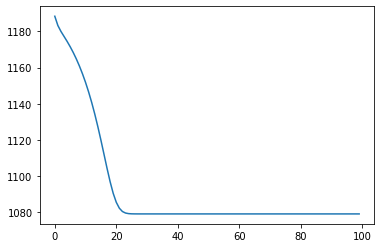

In [50]:
# Perform inference
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
pyro.clear_param_store()
loss = [svi.step(weight, height) for _ in range(100)]
guide = delta_guide.laplace_approximation(weight, height)
plt.plot(loss)
plt.show()

In [51]:
# MAP estimate
delta_guide()

{'alpha': tensor(154.6002, grad_fn=<ExpandBackward>),
 'beta': tensor(0.9052, grad_fn=<ExpandBackward>),
 'sigma': tensor(5.0783, grad_fn=<ExpandBackward>)}

### Code 4.43
Make the same model, but use $\log(\beta)$ as a parameter rather than $\beta$ itself. This will actually be better because now most of our priors are normally distributed (2/3 of 'em), and our posteriors are all Gaussians as well.

In [52]:
# Create model/guide
def create_model():
    def model(weight, height=None):
        alpha = pyro.sample("alpha", Normal(178, 20))
        log_beta = pyro.sample("log_beta", Normal(0, 1))
        sigma = pyro.sample("sigma", Uniform(0, 50))
        mu = alpha + torch.exp(log_beta) * (weight - weight.mean())
        if height is None:
            return pyro.sample("height", Normal(mu, sigma))
        else:
            pyro.sample("height", Normal(mu, sigma), obs=height)

    delta_guide = AutoLaplaceApproximation(
        model,
        init_to_value(values={
            "alpha": height.mean(),
            "sigma": height.std(),
        })
    )
    
    return model, delta_guide

model, delta_guide = create_model()

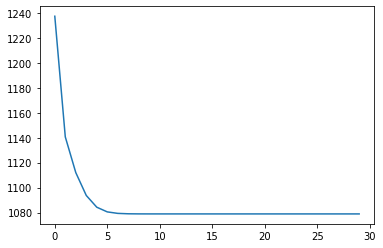

In [53]:
# Perform inference
svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
pyro.clear_param_store()
loss = [svi.step(weight, height) for _ in range(30)]
guide = delta_guide.laplace_approximation(weight, height)
plt.plot(loss)
plt.show()

Man, that converged a lot faster! The MAP estimates are pretty much the same too:

In [54]:
guide()

{'alpha': tensor(154.6072, grad_fn=<ExpandBackward>),
 'log_beta': tensor(-0.0907, grad_fn=<ExpandBackward>),
 'sigma': tensor(5.0107, grad_fn=<ExpandBackward>)}

In [55]:
torch.exp(guide()["log_beta"])

tensor(0.8156, grad_fn=<ExpBackward>)

### Code 4.44/4.45
Look at the summary of the marginal distributions, and the covariance matrix

In [56]:
# Sample from the posterior
samples = {
    k: v.flatten().detach().numpy()
    for k, v in Predictive(model, guide=guide, num_samples=10000)(weight).items()
}
# Transform back to beta; keep in mind it is no longer exactly normally distributed!
samples["beta"] = np.exp(samples["log_beta"])
precis(samples)

,mean,stddev,5.5%,94.5%
alpha,154.602,0.267674,154.18,155.033
log_beta,-0.0995904,0.0464139,-0.173644,-0.0253476
sigma,5.08147,0.191215,4.7793,5.38968
height,154.602,7.75247,142.322,167.137
beta,0.906183,0.0420648,0.840596,0.974971


In [57]:
samples_ = np.vstack([samples[k] for k in ("alpha", "beta", "sigma")])
np.round(np.cov(samples_), 4)

array([[ 0.0717,  0.0001, -0.0001],
       [ 0.0001,  0.0018, -0.0001],
       [-0.0001, -0.0001,  0.0366]])

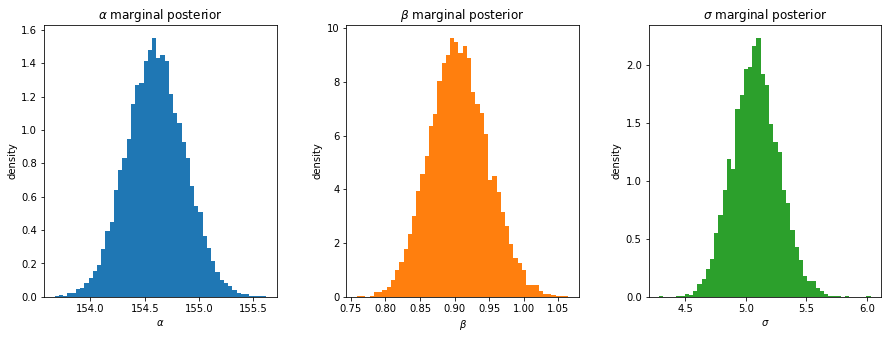

In [58]:
# Plot marginal distributions
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, (var, ax) in enumerate(zip(("alpha", "beta", "sigma"), axes)):
    ax.hist(samples[var], bins=50, color=f"C{i}", density=True)
    ax.set_xlabel(f"$\{var}$")
    ax.set_ylabel("density")
    ax.set_title(f"$\{var}$ marginal posterior")
plt.subplots_adjust(wspace=0.3)
plt.show()

### Code 4.46
Plot the data along with the mean regression line of the posterior

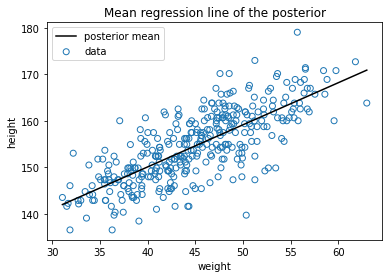

In [59]:
a = samples["alpha"].mean()
b = samples["beta"].mean()
x = np.linspace(weight.min(), weight.max(), 10)
y = a + b * (x - weight.numpy().mean())
plt.scatter(weight, height, label="data", facecolor="none", edgecolor="C0")
plt.plot(x, y, label="posterior mean", color="black")
plt.xlabel("weight")
plt.ylabel("height")
plt.title("Mean regression line of the posterior")
plt.legend()
plt.show()

### Code 4.48/4.49
Redo the analysis for varying levels of data, then sample regression lines from the posterior and plot them with the data

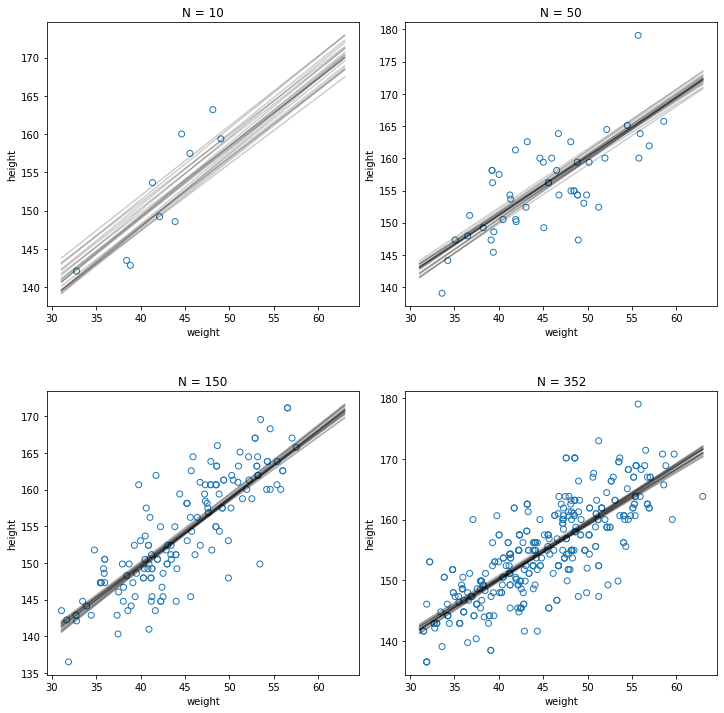

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
for N, ax in zip((10, 50, 150, 352), axes.flatten()):
    # Subsample data
    idx = np.random.choice(len(weight), N)
    weight_, height_ = weight[idx], height[idx]
    # Recreate model/guide
    model, delta_guide = create_model()
    # Perform inference
    svi = SVI(model, delta_guide, optim=SGD({"lr": 1e-3}), loss=Trace_ELBO())
    pyro.clear_param_store()
    loss = [svi.step(weight_, height_) for _ in range(1000)]
    guide = delta_guide.laplace_approximation(weight_, height_)
    # Sample from the posterior
    samples_ = {
        k: v.detach().numpy()
        for k, v in Predictive(model, guide=guide, num_samples=20)(weight_).items()
    }
    # Plot the data
    ax.scatter(weight_, height_, facecolor="none", edgecolor="C0")
    # Plot all sampled lines
    xbar = weight.numpy().mean()
    for i in range(20):
        a = samples_["alpha"][i]
        b = np.exp(samples["log_beta"][i])
        x = np.linspace(weight.min(), weight.max(), 10)
        y = a + b * (x - xbar)
        ax.plot(x, y, color="black", alpha=0.2)
    ax.set_xlabel("weight")
    ax.set_ylabel("height")
    ax.set_title(f"N = {N}")

plt.subplots_adjust(hspace=0.3, wspace=0.15)
plt.show()

### Code 4.50/4.51
Look at the posterior of $\mu$ when weight = 50.

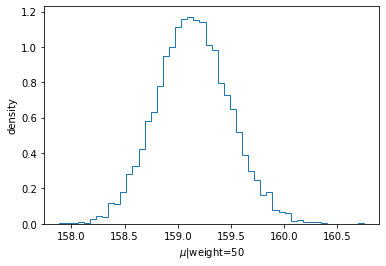

In [61]:
mu50 = samples["alpha"] + samples["beta"] * (50 - weight.numpy().mean())
plt.hist(mu50, density=True, bins=50, histtype="step")
plt.xlabel("$\mu$|weight=50")
plt.ylabel("density")
plt.show()

### Code 4.52
Credible interval of the distribution of $\mu$ when weight = 50

In [62]:
print("quantiles for mu @ 50:", np.quantile(mu50, [0.05, 0.94]))

quantiles for mu @ 50: [158.58248444 159.68039124]


### Code 4.53 - 4.57
Plot the 89% HDPI for the regression line posterior

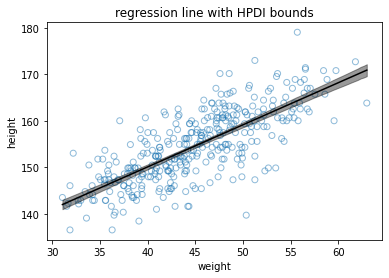

In [63]:
# Find HPDI for regression line
x = np.linspace(weight.min(), weight.max(), 100)
xbar = weight.numpy().mean()
Q1, Q2, m = [], [], []
for i in range(len(x)):
    # Get distribution of mu at each point
    mu = samples["alpha"] + samples["beta"] * (x[i] - xbar)
    # Find HPDI for mu
    q1, q2 = HPDI(mu, prob=0.89)
    # Add to upper/lower/mean interval lists
    Q1.append(q1); Q2.append(q2); m.append(mu.mean())
# Plot
plt.scatter(weight, height, label="data", facecolor="none", edgecolor="C0", alpha=0.5)
plt.fill_between(x, Q1, Q2, color="black", alpha=0.4)
plt.plot(x, m, color="black")
plt.xlabel("weight")
plt.ylabel("height")
plt.title("regression line with HPDI bounds")
plt.show()

### Code 4.58
Detailed explanation of what the `link` function does (in the textbook). Here's the equivalent python code:

In [64]:
samples_ = {
    k: v.detach().numpy()
    for k, v in Predictive(model, guide=guide, num_samples=1000)(weight).items()
}
samples_["beta"] = np.exp(samples_["log_beta"])
mu = samples_["alpha"] + samples_["beta"] * (50 - weight.mean()).numpy()
HPDI(mu, 0.89)

(158.83435, 159.8291)

### Code 4.59 - 4.63
Plot the HPDI of the $h_i$, along with the HPDI of the regression line and the data.

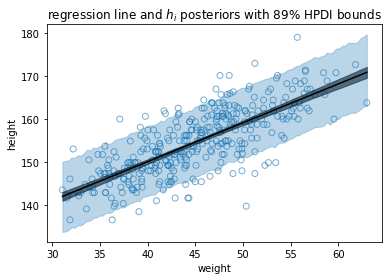

In [65]:
# Find HPDI for regression line and h_i
x = np.linspace(weight.min(), weight.max(), 100)
xbar = weight.numpy().mean()
Q1, Q2, m = [], [], []
Q1_h, Q2_h = [], []
for i in range(len(x)):
    # Get distribution of mu at each point
    mu = samples["alpha"] + samples["beta"] * (x[i] - xbar)
    # Find HPDI for mu
    q1, q2 = HPDI(mu, prob=0.89)
    # Add to upper/lower/mean interval lists
    Q1.append(q1); Q2.append(q2); m.append(mu.mean())
    # Get distribution of h and find HPDI
    h = st.norm(loc=mu, scale=samples["sigma"]).rvs()
    q1, q2 = HPDI(h, prob=0.89)
    Q1_h.append(q1), Q2_h.append(q2)
# Plot
plt.scatter(weight, height, label="data", facecolor="none", edgecolor="C0", alpha=0.6)
plt.fill_between(x, Q1, Q2, color="black", alpha=0.6)
plt.fill_between(x, Q1_h, Q2_h, color="C0", alpha=0.3)
plt.plot(x, m, color="black")
plt.xlabel("weight")
plt.ylabel("height")
plt.title("regression line and $h_i$ posteriors with 89% HPDI bounds")
plt.show()

### Code 4.64
Take a look at the full Howell data (including younger individuals). You can see that there is a clear nonlinear relationship betwen height and weight.

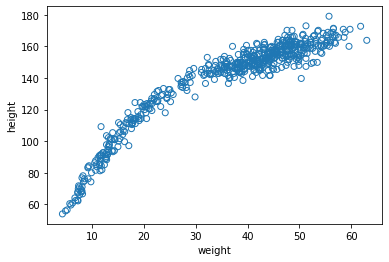

In [66]:
height = tt(howell_df["height"].values).double()
weight = tt(howell_df["weight"].values).double()
plt.scatter(weight, height, facecolor="none", edgecolor="C0")
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

### Code 4.65 - 4.68
Build a (quadratic) polynomial regressor using the model
$$
h_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 \\
\alpha \sim \text{Normal}(178, 20) \\
\beta_1 \sim \text{Log-Normal}(0, 1) \\
\beta_2 \sim \text{Normal}(0, 1) \\
\sigma \sim \text{Uniform}(0, 50)
$$

In [67]:
class PolynomialModel:
    """Model the nonlinear relationship between weight and height."""
    def __init__(self, W, H, p=2):
        # Standardize the data
        self.params = dict(
            W_mean=W.mean(),
            W_std=W.std(),
        )
        self.W_s = self.standardize(W)
        self.H = H
        self.p = p

    def standardize(self, W):
        return (W - self.params["W_mean"])/self.params["W_std"]
        
    def model(self, W=None, train=True):
        sigma = pyro.sample("sigma", Uniform(*tt([0., 50.]).double()))
        alpha = pyro.sample("alpha", Normal(*tt([178., 20.]).double()))
        beta1 = pyro.sample("beta1", LogNormal(*tt([0., 1.]).double()))
        if self.p >= 2:
            betas = {
                k: pyro.sample(f"beta{k}", Normal(*tt([0., 1.]).double()))
                for k in range(2, self.p+1)
            }
        # Standardize input if necessary
        if W is None:
            W_s = self.W_s
        else:
            W_s = self.standardize(W)
        # Calculate mu as polynomial function of standardized weights
        mu = alpha + beta1 * W_s
        if self.p >= 2:
            mu += sum(b*(W_s**k) for k, b in betas.items())
        mu = pyro.deterministic("mu", mu)
        # Sample from heights
        if train:
            pyro.sample("height", Normal(mu, sigma), obs=self.H)
        else:
            return pyro.sample("height", Normal(mu, sigma))

In [68]:
# Make the model/guide
model = PolynomialModel(weight, height, p=2)
delta_guide = AutoLaplaceApproximation(
    model.model,
    init_to_value(values={
        "alpha": height.mean(),
        "sigma": height[height>120].std(),
    })
)
# Infer
pyro.clear_param_store()
svi = SVI(
    model.model,
    delta_guide,
    optim=pyro.optim.Adam({"lr": tt(1e-3).double()}),
    loss=Trace_ELBO()
)
loss = [svi.step() for _ in range(10000)]

In [69]:
# Top it off if necessary
for _ in range(1000):
    loss.append(svi.step())

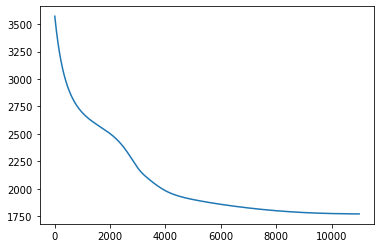

In [70]:
plt.plot(loss)
plt.show()

In [71]:
guide = delta_guide.laplace_approximation()

In [72]:
# Get some samples from the posterior for various weights
n_points = 30
n_samples = 1000
weight_ = torch.linspace(weight.min(), weight.max(), n_points)
samples = {
    k: v.detach().numpy()
    for k, v in Predictive(
        model.model,
        guide=guide,
        num_samples=n_samples
    )(weight_, False).items()
}

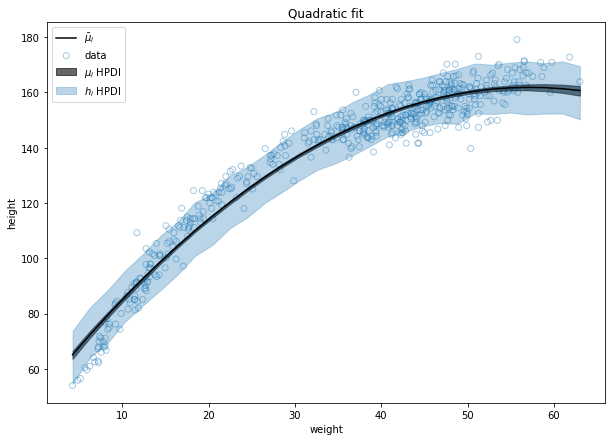

In [73]:
# Calculate mean value of mu and HPDI of mu/height
plt.figure(figsize=(10, 7))
mu = samples["mu"].mean(axis=0)
mu_HPDI = np.vstack([HPDI(samples["mu"][:,i], prob=0.89) for i in range(n_points)])
height_HPDI = np.vstack([HPDI(samples["height"][:,i], prob=0.89) for i in range(n_points)])
# Plot
plt.scatter(weight, height, facecolor="none", edgecolor="C0", alpha=0.4, label="data")
plt.plot(weight_, mu, color="black", label=r"$\bar{\mu}_i$")
plt.fill_between(weight_, *mu_HPDI.T, color="black", alpha=0.6, label=r"$\mu_i$ HPDI")
plt.fill_between(weight_, *height_HPDI.T, color="C0", alpha=0.3, label=r"$h_i$ HPDI")
plt.legend()
plt.xlabel("weight")
plt.ylabel("height")
plt.title("Quadratic fit")
plt.show()

### Code 4.69
Do regression on a linear, quadratic, and cubic model and compare them

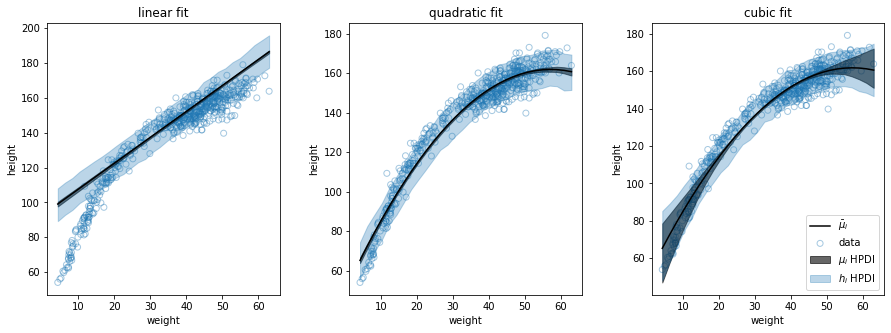

In [74]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for p, label, ax in zip((1, 2, 3), ("linear", "quadratic", "cubic"), axes):
    # Make the model/guide
    model = PolynomialModel(weight, height, p)
    delta_guide = AutoLaplaceApproximation(
        model.model,
        init_to_value(values={
            "alpha": height.mean(),
            "sigma": height[height>120].std(),
        })
    )
    # Infer
    pyro.clear_param_store()
    svi = SVI(
        model.model,
        delta_guide,
        optim=pyro.optim.Adam({"lr": 1e-3}),
        loss=Trace_ELBO()
    )
    loss = [svi.step() for _ in range(10000)]
    # Get some samples from the posterior for various weights
    n_points = 30
    n_samples = 1000
    weight_ = torch.linspace(weight.min(), weight.max(), n_points)
    pred = Predictive(model.model, guide=guide, num_samples=n_samples)
    samples = {k: v.detach().numpy() for k, v in pred(weight_, False).items()}
    # Calculate mean value of mu and HPDI of mu/height
    mu = samples["mu"].mean(axis=0)
    mu_HPDI = np.vstack([HPDI(samples["mu"][:,i], prob=0.89) for i in range(n_points)])
    height_HPDI = np.vstack([HPDI(samples["height"][:,i], prob=0.89) for i in range(n_points)])
    # Plot
    ax.scatter(weight, height, facecolor="none", edgecolor="C0", alpha=0.4, label="data")
    ax.plot(weight_, mu, color="black", label=r"$\bar{\mu}_i$")
    ax.fill_between(weight_, *mu_HPDI.T, color="black", alpha=0.6, label=r"$\mu_i$ HPDI")
    ax.fill_between(weight_, *height_HPDI.T, color="C0", alpha=0.3, label=r"$h_i$ HPDI")
    ax.set_xlabel("weight")
    ax.set_ylabel("height")
    ax.set_title(f"{label} fit")

plt.legend(loc="lower right")
plt.subplots_adjust(wspace=0.3)
plt.show()

We can see that in the cubic model, the model is very uncertain about the coefficient of the cubic term `beta3` itself, which is what is causing the large HPDI around the extremities of the data.

In [75]:
precis(samples)

,mean,stddev,5.5%,94.5%
sigma,5.80735,0.183521,5.51477,6.11059
alpha,145.702,0.368908,145.146,146.267
beta1,21.9318,0.288847,21.4872,22.3977
beta2,-7.46576,0.282811,-7.9122,-6.99192
beta3,-0.0229301,1.02666,-1.75607,1.60949
height,132.042,30.7498,73.958,166.999
mu,132.025,30.1946,74.4209,163.415


### Code 4.72
Load data for Japanese cherry blossom blooming

In [76]:
blossom_df = pd.read_csv("data/cherry_blossoms.csv", sep=";")
blossom_df.sample(5)

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1162,1963,101.0,7.75,8.35,7.14
396,1197,NaN,5.92,6.60,5.24
1119,1920,104.0,6.50,7.04,5.96
745,1546,112.0,5.61,6.54,4.68


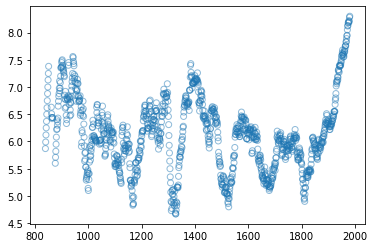

In [77]:
d = blossom_df[blossom_df["year"].between(839, 1980)]
plt.scatter(d["year"], d["temp"], alpha=0.5, color="C0", facecolor="none")
plt.show()

### Code 4.73 - 4.75
Construct B-spline basis functions

In [78]:
class BSpline(nn.Module):
    def __init__(self, knots, degree, precompute=False):
        super().__init__()
        self.knots = knots
        self.degree = degree
        self.n_basis = len(knots) + 2
        self.params = nn.Parameter(torch.randn(self.n_basis))
        self.precompute = precompute
        self.cached_B = None
        
    def _a(self, i, j, x):
        """Calculate the coefficients of the recurrence relation"""
        t = self.knots
        if i < 0:
            ti = t[0]
        elif i >= len(t):
            ti = t[-1]
        else:
            ti = t[i]
        if i + j < 0:
            tij = t[0]
        elif i + j >= len(t):
            tij = t[-1]
        else:
            tij = t[i+j]
        if ti == tij:
            return torch.zeros_like(x)
        return (x - ti)/(tij - ti)
    
    def basis(self, i: int, n: int, x: torch.Tensor):
        """A single spline basis function"""
        t = self.knots
        if n == 0:
            try:
                return ((t[i] <= x) & (x < t[i+1])).type(x.dtype)
            except IndexError:
                if i < 0:
                    ti = t[0]
                elif i >= len(t):
                    ti = t[-1]
                else:
                    ti = t[i]
                if i + 1 < 0:
                    tij = t[0]
                elif i + 1 >= len(t):
                    tij = t[-1]
                else:
                    tij = t[i+1]
                return ((ti <= x) & (x < tij)).type(x.dtype)
        return (
            self._a(i, n, x) * self.basis(i, n-1, x)
            + (1 - self._a(i+1, n, x)) * self.basis(i+1, n-1, x)
        ).type(x.dtype)
    
    def B(self, x):
        """The matrix of basis functions evaluated at points x"""
        range_ = range(-self.degree, len(self.knots)-self.degree+2)
        B = torch.stack([self.basis(i, self.degree, x) for i in range_], axis=0)
        return B
    
    def forward(self, x):
        """Compute the forward pass over the data"""
        # FIXME: is this ever actually called in the below implementation?
        # Did this even need to subclass nn.Module?
        if not self.precompute or (self.precompute and (self.cached_B is None)):
            B = self.B(x)
            self.cached_B = B
        else:
            B = self.cached_B
        B = (self.params.view(-1, 1) * B).sum(axis=0)
        return B

In [79]:
knots = np.quantile(d["year"], np.linspace(0, 1, 15))
s = BSpline(tt(knots), degree=3)

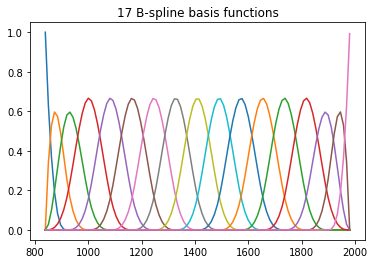

In [80]:
x = torch.linspace(knots[0], .9999*knots[-1], 100)
k = s.degree
for j in range(-k, -k+len(knots)+2):
    b = s.basis(j, s.degree, x)
    plt.plot(x, b)
plt.title(f"{s.n_basis} B-spline basis functions")
plt.show()

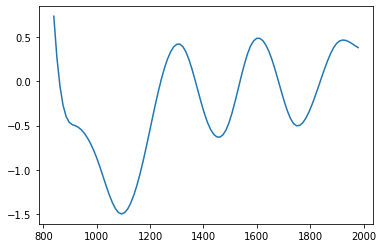

In [81]:
plt.plot(x, s(x).detach())
plt.show()

### Code 4.76
Perform regression on this time series where $\mu_i$ is B-spline. The model we will be using can be described by:

$$
T_i \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i = \alpha + \sum_{k=1}^K w_k B_{ki} \\
\alpha \sim \text{Normal}(6, 10) \\
w_j \sim \text{Normal}(0, 1) \\
\sigma \sim \text{Exponential}(1)
$$

where $B_{ki}$ is the value of the $k$th B-spline basis function evaluated on the $i$th data point. Because these values don't change, it doesn't make sense to evaluate the basis functions every time we make a pass over the dataset, which is why we added caching in the above B-spline implementation.

In [82]:
# Having some trouble with the Laplace approximation for some reason
from pyro.infer.autoguide import AutoDiagonalNormal

In [83]:
class SplineRegression:
    def __init__(self, x, y, knots, degree=3):
        # standardize the data
        self.params = dict(x_mean=x.mean(), x_std=x.std())
        self.x_s = self.standardize(x)
        self.y = y
        # initialize spline
        knots = self.standardize(knots)
        self.spline = BSpline(knots, degree, precompute=True)
        self.spline(self.x_s)
        # priors
        self.alpha_prior = Normal(*tt([6., 10.]).double())
        self.W_prior = Normal(*tt([0., 1.]).double()).expand([self.spline.n_basis])
        self.sigma_prior = Exponential(1.)
        self.guide = None
        
    def standardize(self, x):
        return (x - self.params["x_mean"])/self.params["x_std"]
        
    def model(self, x=None):
        alpha = pyro.sample("alpha", self.alpha_prior).double()
        W = pyro.sample("W", self.W_prior).double()
        sigma = pyro.sample("sigma", self.sigma_prior).double()
        if x is None:
            x_s = self.x_s
            mu = alpha + (W.view(-1, 1) * self.spline.cached_B).sum(axis=0).double()
            pyro.deterministic("mu", mu)
            pyro.sample("T", Normal(mu, sigma), obs=y)
        else:
            x_s = self.standardize(x)
            mu = alpha + (W.view(-1, 1) * self.spline.B(x_s)).sum(axis=0)
            pyro.deterministic("mu", mu)
            return pyro.sample("T", Normal(mu, sigma))
        
    def train(self, n_steps=10_000):
        # Set up autoguide
        self.guide = AutoDiagonalNormal(
        self.model,
        init_to_value(values={
                "alpha": tt(8.).double(),
                "sigma": tt(1.).double(),
                "W": torch.zeros(self.spline.n_basis).double(),
            })
        )
        # Infer
        pyro.clear_param_store()
        svi = SVI(
            self.model,
            self.guide,
            optim=pyro.optim.Adam({"lr": tt(1e-3).double()}),
            loss=Trace_ELBO()
        )
        loss = list()
        for _ in tqdm.notebook.trange(n_steps):
            step_loss = svi.step()
            loss.append(step_loss)
        return loss

In [84]:
# Prepare data and train model
mask = ~(d["year"].isna() | d["temp"].isna())
x = tt(d.loc[mask, "year"].values).double()
y = tt(d.loc[mask, "temp"].values).double()
knots = tt(np.quantile(x, np.linspace(0, 1, 15)))
knots[-1] = 1.001*x.max()
model = SplineRegression(x, y, knots, degree=3)
loss = model.train(10_000)

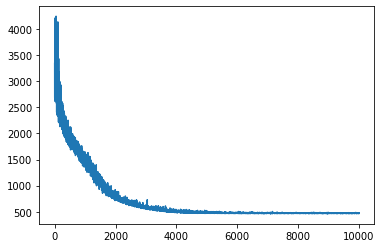

In [85]:
plt.plot(loss)
plt.show()

In [86]:
model.guide()

{'alpha': tensor(6.8651, dtype=torch.float64, grad_fn=<ExpandBackward>),
 'W': tensor([-0.5537, -0.2936,  0.7794, -1.3925, -0.4548, -1.8498,  0.6733, -2.4093,
          1.8118, -2.7694,  0.4281, -2.0801, -0.4957, -1.7448, -0.5039,  0.4505,
          1.5777], dtype=torch.float64, grad_fn=<ExpandBackward>),
 'sigma': tensor(0.3470, dtype=torch.float64, grad_fn=<ExpandBackward>)}

In [87]:
# Sample from the posterior
num_samples = 500
x_ = torch.linspace(x.min(), x.max(), 100)
samples = {
    k: v.detach().numpy()
    for k, v in Predictive(
        model.model,
        guide=model.guide,
        num_samples=num_samples,
        return_sites=("T", "mu")
    )(x_).items()
}

In [88]:
# Calculate HPDI intervals
hpdi = {k: np.zeros(shape=(len(x_), 2)) for k in ("T", "mu")}
for k in hpdi:
    for i in range(len(hpdi[k])):
        hpdi[k][i] = HPDI(samples[k][:,i], prob=0.89)

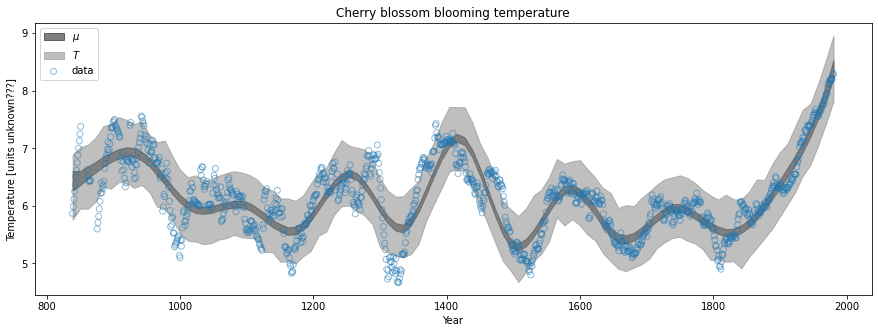

In [89]:
# Visualize results!
plt.figure(figsize=(15, 5))
plt.fill_between(x_, *hpdi["mu"].T, alpha=0.5, color="black", label="$\mu$")
plt.fill_between(x_, *hpdi["T"].T, alpha=0.5, color="gray", label="$T$")
plt.scatter(x, y, facecolor="none", edgecolor="C0", alpha=0.5, label="data")
plt.legend()
plt.title("Cherry blossom blooming temperature")
plt.xlabel("Year")
plt.ylabel("Temperature [units unknown???]")
plt.show()